In [13]:
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import tensorflow as tf
from random import sample
from os import mkdir, listdir
from collections import Counter
import matplotlib.pyplot as plt
from shutil import copyfile, rmtree
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [14]:
train_dir = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train"
valid_dir = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val"
test_dir = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"

In [15]:
import os
import cv2
import numpy as np

target_size = (1300, 650)

def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if not os.path.isdir(label_path):
            continue
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue  
            image = cv2.resize(image, target_size)
            image = image / 255.0
            images.append(image)
            labels.append(label)
    images = np.array(images).reshape(-1, target_size[0], target_size[1], 1)
    return images, labels

# Load datasets (ensure train_dir, valid_dir, and test_dir are defined)
train_images, train_labels = load_images_from_directory(train_dir, target_size)
valid_images, valid_labels = load_images_from_directory(valid_dir, target_size)
test_images, test_labels = load_images_from_directory(test_dir, target_size)


Training Set Samples:


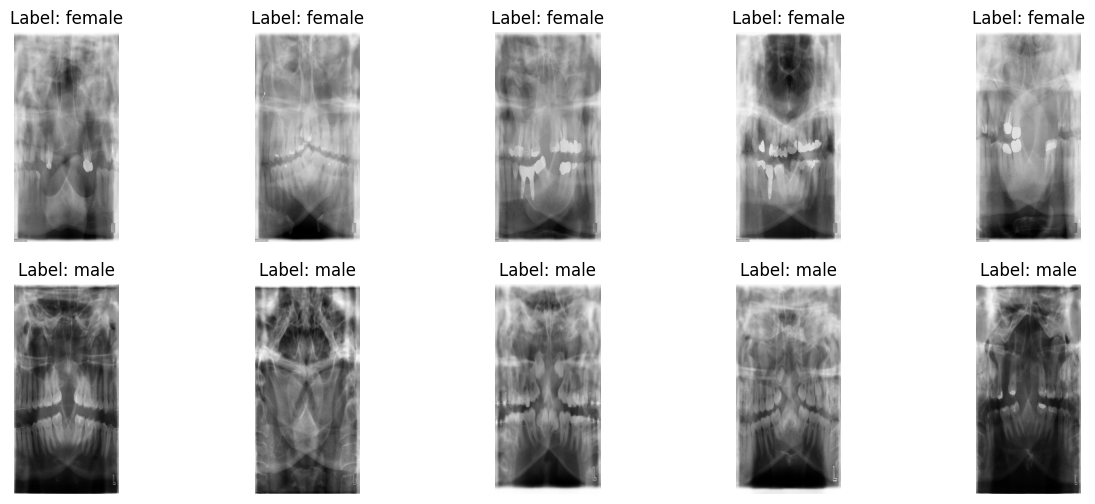

In [16]:
import matplotlib.pyplot as plt

def display_images(images, labels, num_images=5):
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(len(unique_labels), num_images, figsize=(15, len(unique_labels)*3))
    for i, label in enumerate(unique_labels):
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        for j in range(num_images):
            if j < len(label_images):
                ax = axes[i, j]
                ax.imshow(label_images[j].reshape(target_size[0], target_size[1]), cmap='gray', vmin=0, vmax=1)
                ax.set_title(f"Label: {label}")
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.show()

print("Training Set Samples:")
display_images(train_images, train_labels)


In [17]:
# Label encoding
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# Convert to numpy arrays
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

# Shuffle training data
def shuffle_data(images, labels):
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    return images[indices], labels[indices]

train_images, train_labels = shuffle_data(train_images, train_labels)


In [18]:
# Create feature extractor
feature_extractor = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(1300, 650, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    GlobalAveragePooling2D()
])

# Extract features
print("Extracting training features...")
train_features = feature_extractor.predict(train_images)
print("Extracting validation features...")
valid_features = feature_extractor.predict(valid_images)
print("Feature extraction complete!")

Extracting training features...
22/22 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step
Extracting validation features...
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Feature extraction complete!


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def pso_feature_selection(X, y, n_particles=10, n_iterations=20):
    n_features = X.shape[1]
    particles = np.random.randint(0, 2, (n_particles, n_features))
    velocities = np.zeros((n_particles, n_features))
    personal_best = particles.copy()
    personal_best_scores = np.zeros(n_particles)
    global_best = particles[0].copy()
    global_best_score = -np.inf

    for _ in range(n_iterations):
        for i in range(n_particles):
            mask = particles[i].astype(bool)
            if np.sum(mask) == 0:
                score = 0.0
            else:
                X_subset = X[:, mask]
                X_train, X_val, y_train, y_val = train_test_split(
                    X_subset, y, test_size=0.2, random_state=42
                )
                clf = RandomForestClassifier(random_state=42)
                clf.fit(X_train, y_train)
                score = clf.score(X_val, y_val)
            
            if score > personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best[i] = particles[i].copy()
            
            if score > global_best_score:
                global_best_score = score
                global_best = particles[i].copy()

        w = 0.9
        c1 = 0.5
        c2 = 0.5
        for i in range(n_particles):
            r1 = np.random.rand(n_features)
            r2 = np.random.rand(n_features)
            velocities[i] = (
                w * velocities[i] +
                c1 * r1 * (personal_best[i] - particles[i]) +
                c2 * r2 * (global_best - particles[i])
            )
            particles[i] = np.where(
                np.random.rand(n_features) < 1 / (1 + np.exp(-velocities[i])),
                1, 0
            )

    return global_best

def gwo_feature_selection(X, y, n_wolves=10, n_iterations=20):
    n_features = X.shape[1]
    wolves = np.random.randint(0, 2, (n_wolves, n_features))
    alpha = wolves[0].copy()
    beta = wolves[1].copy()
    delta = wolves[2].copy()
    alpha_score = -np.inf

    for iter in range(n_iterations):
        for i in range(n_wolves):
            mask = wolves[i].astype(bool)
            if np.sum(mask) == 0:
                score = 0.0
            else:
                X_subset = X[:, mask]
                X_train, X_val, y_train, y_val = train_test_split(
                    X_subset, y, test_size=0.2, random_state=42
                )
                clf = RandomForestClassifier(random_state=42)
                clf.fit(X_train, y_train)
                score = clf.score(X_val, y_val)
            
            if score > alpha_score:
                alpha_score = score
                alpha = wolves[i].copy()
            elif score > alpha_score * 0.9:
                beta = wolves[i].copy()
            elif score > alpha_score * 0.8:
                delta = wolves[i].copy()

        a = 2 - 2 * (iter / n_iterations)
        for i in range(n_wolves):
            A1 = 2 * a * np.random.rand(n_features) - a
            C1 = 2 * np.random.rand(n_features)
            D_alpha = np.abs(C1 * alpha - wolves[i])
            X1 = alpha - A1 * D_alpha

            A2 = 2 * a * np.random.rand(n_features) - a
            C2 = 2 * np.random.rand(n_features)
            D_beta = np.abs(C2 * beta - wolves[i])
            X2 = beta - A2 * D_beta

            A3 = 2 * a * np.random.rand(n_features) - a
            C3 = 2 * np.random.rand(n_features)
            D_delta = np.abs(C3 * delta - wolves[i])
            X3 = delta - A3 * D_delta

            new_position = (X1 + X2 + X3) / 3
            wolves[i] = np.where(
                np.random.rand(n_features) < 1 / (1 + np.exp(-new_position)),
                1, 0
            )

    return alpha

# Example usage (assuming train_features and train_labels are defined):
print("Running PSO feature selection with RandomForestClassifier...")
best_mask_pso = pso_feature_selection(train_features, train_labels)
print("Running GWO feature selection with RandomForestClassifier...")
best_mask_gwo = gwo_feature_selection(train_features, train_labels)

# Combine feature selections
final_mask = np.logical_or(best_mask_pso, best_mask_gwo).astype(np.float32)
print(f"Selected {np.sum(final_mask)} features out of {len(final_mask)}")


Running PSO feature selection with RandomForestClassifier...
Running GWO feature selection with RandomForestClassifier...
Selected 50.0 features out of 64


In [20]:
# Create mask layer
mask_layer = Lambda(lambda x: x * final_mask)

# Build final model
CNN_Model = Sequential([
    feature_extractor,
    mask_layer,
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

CNN_Model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

CNN_Model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,089 (98.00 KB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = CNN_Model.fit(
    train_images, train_labels,
    epochs=50,
    validation_data=(valid_images, valid_labels),
    batch_size=8,
    verbose=1
)


Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.5075 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6915
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 325s 4s/step - accuracy: 0.4910 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.5035 - loss: 0.6901 - val_accuracy: 0.5000 - val_loss: 0.6899
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.5481 - loss: 0.6895 - val_accuracy: 0.5000 - val_loss: 0.6886
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 300s 3s/step - accuracy: 0.5710 - loss: 0.6874 - val_accuracy: 0.5000 - val_loss: 0.6865
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 321s 4s/step - accuracy: 0.5426 - loss: 0.6870 - val_accuracy: 0.5000 - val_loss: 0.6840
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.5699 - loss: 0.6831 - val_accuracy: 0.5000 - val_loss: 0.6803
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.5847 - loss: 0.6767 - val_accuracy: 0.5204 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8478 - loss: 0.3063

Test Accuracy: 78.35%
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Classification Report:
              precision    recall  f1-score   support

      female       0.71      0.98      0.82        49
        male       0.97      0.58      0.73        48

    accuracy                           0.78        97
   macro avg       0.84      0.78      0.77        97
weighted avg       0.83      0.78      0.77        97



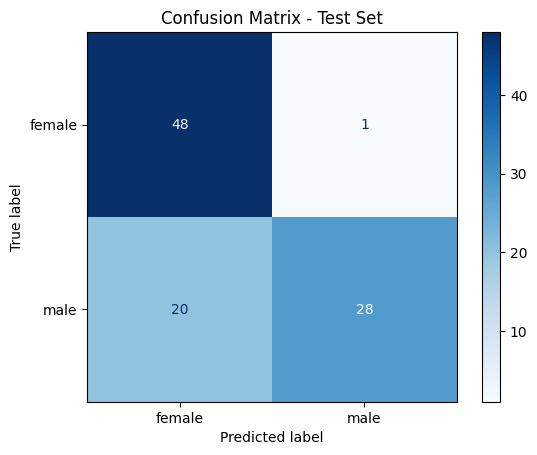

In [22]:
# Evaluate on test set
test_loss, test_accuracy = CNN_Model.evaluate(test_images, test_labels)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# Classification Report
y_pred_probs = CNN_Model.predict(test_images)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(test_labels, y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()


In [23]:
# Save model in proper format
CNN_Model.save('gender_classification_pso_gwo.keras')  # Use .keras extension

# Load model with custom layer support
loaded_model = load_model('gender_classification_pso_gwo.keras', custom_objects={'Lambda': Lambda})

ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

In [ ]:
def predict_gender(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")
    
    processed_image = cv2.resize(image, target_size) / 255.0
    processed_image = np.expand_dims(processed_image, axis=(0, -1))  # Shape: (1, 1300, 650, 1)
    
    prediction = loaded_model.predict(processed_image)
    predicted_class = "Male" if prediction[0][0] > 0.5 else "Female"
    confidence = abs(prediction[0][0] - 0.5) * 200  # Convert to percentage
    
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted Gender: {predicted_class}\nConfidence: {confidence:.1f}%")
    plt.axis('off')
    plt.show()

# Example usage
test_image_path = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\female\\female.445.JPG"
predict_gender(test_image_path)

NameError: name 'loaded_model' is not defined